In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [11]:
train_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

test_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

In [12]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [13]:
test_data = add_features(test_data.copy())
train_data = add_features(train_data.copy())

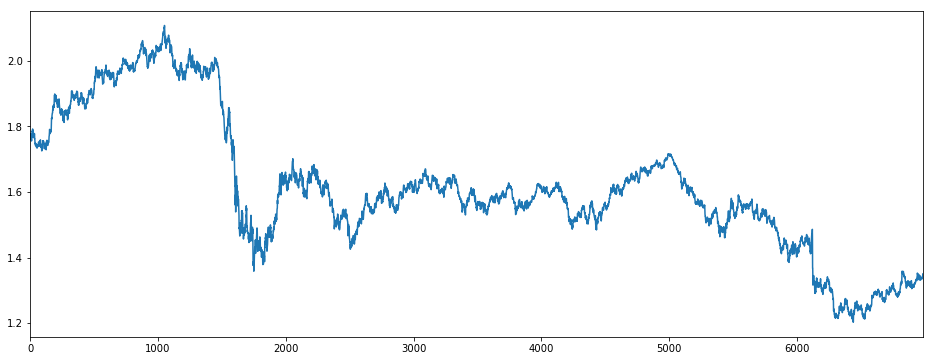

In [14]:
test_data['price'].plot(figsize=(16,6))

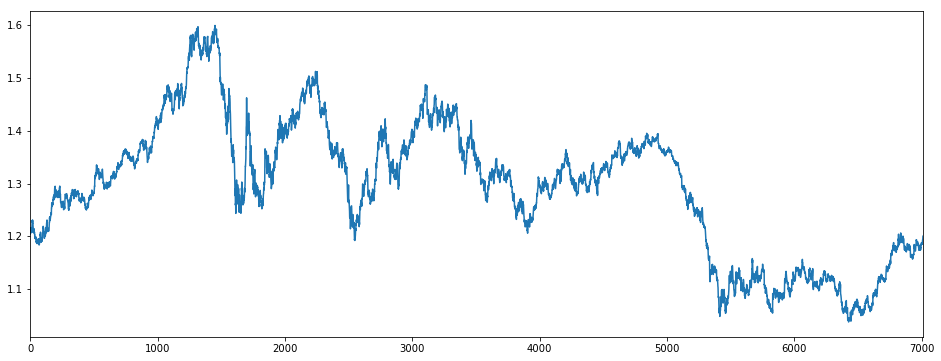

In [15]:
train_data['price'].plot(figsize=(16,6))

In [17]:
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 7010, test size 6988


In [18]:
episode=1000
batch_size=10

In [19]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-12 12:00:00,1.20430,1.21392,1.20072,1.21368,1.20430,0.419520,0.007157,0.451709
1,1,2006-01-13 00:00:00,1.20542,1.20832,1.20300,1.20440,1.20542,0.419520,0.006696,0.398502
2,2,2006-01-13 12:00:00,1.21430,1.21460,1.20368,1.20542,1.21430,0.552122,0.007754,0.378511
3,3,2006-01-15 12:00:00,1.21640,1.21750,1.21310,1.21310,1.21640,0.600721,0.006915,0.361738
4,4,2006-01-16 00:00:00,1.21322,1.21720,1.21312,1.21650,1.21322,0.600721,0.006205,0.310090


In [21]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [22]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 57 pips, median trade count: 562
....................
episode: 40/1000
median profit: -683 pips, median trade count: 549
....................
episode: 60/1000
median profit: -470 pips, median trade count: 525
....................
episode: 80/1000
median profit: 57 pips, median trade count: 520
....................
episode: 100/1000
median profit: 77 pips, median trade count: 528
....................
episode: 120/1000
median profit: 57 pips, median trade count: 539
....................
episode: 140/1000
median profit: 180 pips, median trade count: 539
....................
episode: 160/1000
median profit: 385 pips, median trade count: 546
....................
episode: 180/1000
median profit: 425 pips, median trade count: 551
....................
episode: 200/1000
median profit: 605 pips, median trade count: 551
....................
episode: 220/1000
median profit: 521 pips, median trade count: 550
....................
episode: 240/10

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.784320). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


......
episode: 560/1000
median profit: 1351 pips, median trade count: 489
.............

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.155544). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.......
episode: 580/1000
median profit: 1411 pips, median trade count: 490
....................
episode: 600/1000
median profit: 1519 pips, median trade count: 490
....................
episode: 620/1000
median profit: 1541 pips, median trade count: 489
...

/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.246296). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


.................
episode: 640/1000
median profit: 1618 pips, median trade count: 489
....................
episode: 660/1000
median profit: 1649 pips, median trade count: 488
....................
episode: 680/1000
median profit: 1603 pips, median trade count: 488
....................
episode: 700/1000
median profit: 1603 pips, median trade count: 487
....................
episode: 720/1000
median profit: 1618 pips, median trade count: 484
....................
episode: 740/1000
median profit: 1728 pips, median trade count: 484
....................
episode: 760/1000
median profit: 1833 pips, median trade count: 482
....................
episode: 780/1000
median profit: 1887 pips, median trade count: 483
....................
episode: 800/1000
median profit: 1917 pips, median trade count: 484
....................
episode: 820/1000
median profit: 1917 pips, median trade count: 483
....................
episode: 840/1000
median profit: 1983 pips, median trade count: 482
....................
epi

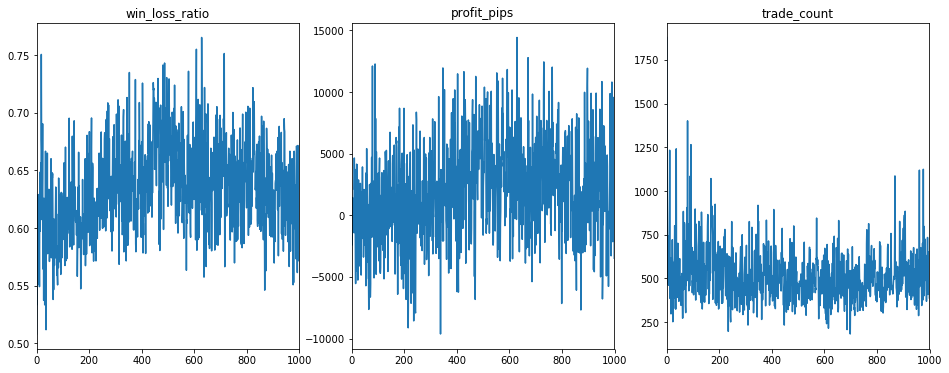

In [23]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [24]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['12h-EUR_USD_GBP_USD.pkl']

## Test

In [25]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [26]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [27]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [28]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 8821.549999999483 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138f08650>]],
      dtype=object)

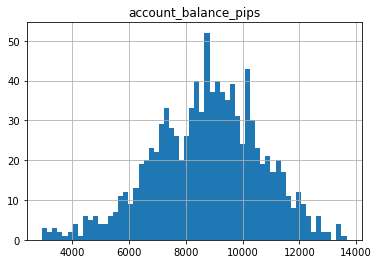

In [29]:
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

## Analyse positions on test data

In [30]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [31]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [32]:
env._stats()

{'trade_count': 1424,
 'win_loss_ratio': 0.5414325842696629,
 'account_balance': 1.1344599999999456,
 'unrealised_pl': 0}

In [33]:
position_data = env.price_data.copy()

In [34]:
position_data['position'] = position_data['position'] - 1

In [35]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

1425 positions to plot...


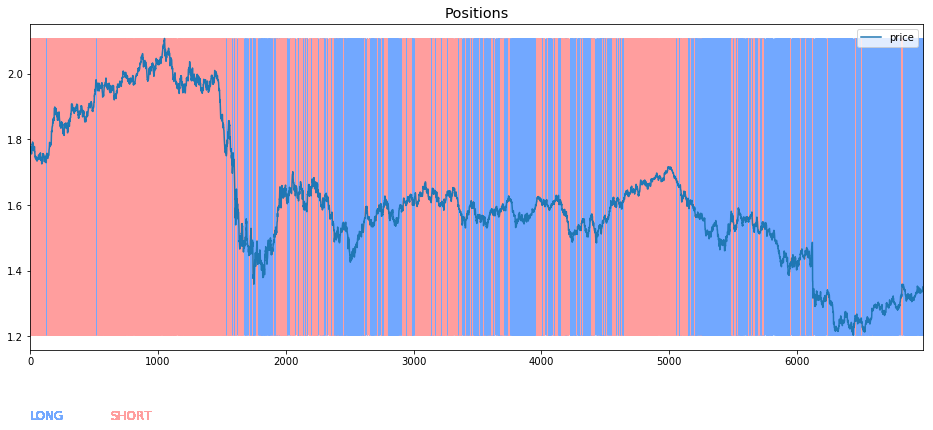

In [36]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [37]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 54.81%
Ratio of long to short positions: 1.18
Median profit: 0.0
Total profit: 1.2412600000000114
Median position length: 1.0
Number of trades: 1425


In [38]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2006-01-12 12:00:00,1.76080,2006-01-13 00:00:00,1.76665,1,NaN,NaN,False,NaN
1,2006-01-13 00:00:00,1.76665,2006-01-17 12:00:00,1.76680,6,-1.0,-0.00015,False,-0.00015
2,2006-01-18 00:00:00,1.76635,2006-02-07 00:00:00,1.74845,31,-1.0,0.01790,True,0.01775
3,2006-02-07 12:00:00,1.74665,2006-02-08 12:00:00,1.74140,2,-1.0,0.00525,True,0.02300
4,2006-02-09 00:00:00,1.74270,2006-02-15 00:00:00,1.73915,9,-1.0,0.00355,True,0.02655
...,...,...,...,...,...,...,...,...,...
1420,2017-09-18 00:00:00,1.35422,2017-09-18 12:00:00,1.35148,1,-1.0,0.00274,True,1.23333
1421,2017-09-18 12:00:00,1.35148,2017-09-20 12:00:00,1.34901,4,1.0,-0.00247,False,1.23086
1422,2017-09-21 00:00:00,1.34846,2017-09-22 00:00:00,1.35610,2,1.0,0.00764,True,1.23850
1423,2017-09-22 12:00:00,1.34966,2017-12-01 00:00:00,1.35030,109,1.0,0.00064,True,1.23914


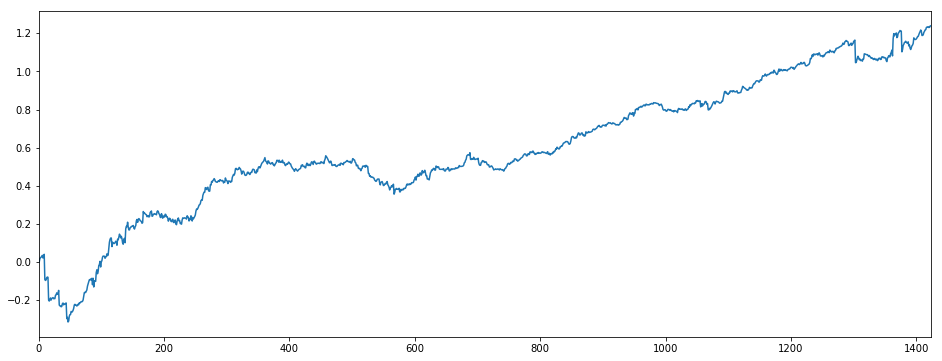

In [39]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.2578800000000002


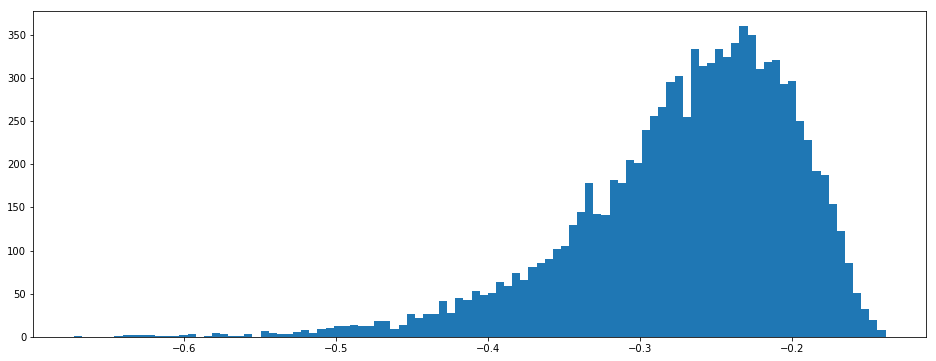

In [40]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);